# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import csv
from scipy.stats import linregress
from ratelimiter import RateLimiter
import datetime
#from datetime import datetime  <- inserting this here broke stuff further down.  no clue why.

# Import API key
from api_keys import weather_api_key

# Imported citipy to determine city based on latitude and longitude
from citipy import citipy
from geopy.distance import geodesic

# Output File path (CSV)
# Plots will go in same folder
outputCSV = "outputData/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)
equator = 0  # Used to determine North or South hemisphere
rateLimiter = RateLimiter(max_calls = 1, period = 1) # Keeps from blowing up API key and locking it

# set up API call
url ='http://api.openweathermap.org/data/2.5/weather?'
units = 'imperial'
queryURL = f'{url}appid={weather_api_key}&units={units}&q='

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
# Small set for debugging
# lats = np.random.uniform(lat_range[0], lat_range[1], size=25)
# lngs = np.random.uniform(lng_range[0], lng_range[1], size=25)
# Big set for final results
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)
# Identify nearest city for each lat, lng combination
# Note, most of the lat long combos are far away from any landmass
# Nearest city may be 100's of miles away.
# As a result, coastal cities and points on peninsulas are heavily over represented.
# Places like Hilo, Barrow, Ushuaia, New Norfolk, Hobart and Cape Town show up repeatedly.
# Add error checking where if the city is > 50 miles away from the random lat/long it gets thrown out
# and you might get a better sample of interior weather stations.
# This is especially true in southern hemisphere where there is significantly more water than land mass.

for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
       # print(f'{city:21} {lat_lng[0]:20}, {lat_lng[1]:19}') # for debugging
     
# Print the city count to confirm sufficient count
totalCities = len(cities)

print(f'We start with {totalCities} cities')

We start with 629 cities


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# set up empty lists for the different json parts we want
lat = []
long = []
maxTemp = []
feelsLike =[]
hum = []
cloud = []
wind = []
country = []
date = []
measurementDate = []
weatherData = []
NS = []
south = 0
north = 0
NH = 'for the Northern Hemisphere on'
SH = 'for the Southern Hemisphere on'
# Loop through the list of cities.  The try loop appends data cities that have weather data
# The exception prints "no Data for CITY NAME" and doesn't add the city set since there's no point in
# tracking it - it causes breaks data frames if you include it
# response grabs a city name
# everything else grabs bits from the JSON
# weatherData.append creates a data dict for the city info using the bits grabbed above
x = 0
y = 0

# debugging cities
# cities = ['London', 'los angeles', 'san diego', 'lima']
for city in cities:
    with rateLimiter:
        try:  # Try's make bughunting hard since they don't obviously break anything. grrrr
              # If you get only get "No data for {city x}" then there is a bug in the try section
              # comment out the try: and except: lines and   
            response = requests.get(queryURL + city).json()
            lat.append(response['coord']['lat'])
            long.append(response['coord']['lon'])
            maxTemp.append(response['main']['temp_max'])
            feelsLike.append(response['main']['feels_like'])
            hum.append(response['main']['humidity'])
            cloud.append(response['clouds']['all'])
            wind.append(response['wind']['speed'])
            country.append(response['sys']['country'])
            date.append(response['dt'])
            if lat[x] < 0:
                NS = 'Southern'    # Add hemisphere column to dataframe
                south = south + 1  # Count number of cities in each hemisphere
            else:
                NS = 'Northern'
                north = north + 1
                
            # convert UNIX time into human readable.  I suspect I made this a step longer than necessary.
            # The subscript stuff is weird
            measurementDate = datetime.datetime.utcfromtimestamp(date[x])
            # Build the data frame line by line
            weatherData.append({ 'City': city.title(), 'Country': country[x], 'Hemisphere':NS,'Latitude':lat[x], 
                                'Longitude':long[x],'Max Temp (F)':maxTemp[x], 'Humidity':hum[x], 
                                'Feels Like':feelsLike[x], 'Cloudiness':cloud[x], 'Wind Speed (MPH)':wind[x],
                                'Date and Time of Reading (UTC)':measurementDate })
           
            # print the city name and count (formatted for easy to read columns)
            print(f'Weather retrieved for {city.title():28} (city number {(x + 1) :3}) at   {measurementDate} UTC')
            x = x +1
        except:
            #discard city
            print(f'No data for {city.title()}')
            y = y + 1

# Extra statistics for my amusement
print(f'\n\n-------------------------------------------------------\n')

print(f'We started with {totalCities} cities')
print(f'\nWe have weather data for {len(weatherData)} cities')
if y == 1:
    print(f'\nWe dropped {y} city from the list\n')
else:
    print(f'\nWe dropped {y} cities ({round((y / (x+y)) * 100, 0)}%) from the list\n')
    
print(f'We have {north} Northern Hemisphere cities')
print(f'We have {south} Southern Hemisphere cities') 
print(f'{round((north / (north + south) * 100), 2)}% of the cities are in the Northern Hemisphere')
print(f'{round((south / (north + south) * 100), 2)}% of the cities are in the Southern Hemisphere\n')
print(f'-------------------------------------------------------')
# used this when I was having trouble creating a data frame because not all columns (rows?) were equal
#print(len(cities), len(lat), len(lon),len(maxTemp),len(hum),len(cloud),len(wind),len(country),len(date))
#weather_data = pd.DataFrame(weatherDict)
#weather_data.head()

Weather retrieved for Sitka                        (city number   1) at   2021-01-03 05:46:03 UTC
No data for Tsihombe
No data for Ondorhaan
Weather retrieved for Khatanga                     (city number   2) at   2021-01-03 05:46:11 UTC
No data for Boatlaname
Weather retrieved for Thompson                     (city number   3) at   2021-01-03 05:50:52 UTC
Weather retrieved for Barrow                       (city number   4) at   2021-01-03 05:50:53 UTC
Weather retrieved for Faanui                       (city number   5) at   2021-01-03 05:50:55 UTC
Weather retrieved for East London                  (city number   6) at   2021-01-03 05:50:56 UTC
Weather retrieved for Ushuaia                      (city number   7) at   2021-01-03 05:50:57 UTC
Weather retrieved for Inirida                      (city number   8) at   2021-01-03 05:50:59 UTC
Weather retrieved for Bowen                        (city number   9) at   2021-01-03 05:51:00 UTC
Weather retrieved for Deder                        (

Weather retrieved for Huarmey                      (city number  84) at   2021-01-03 05:52:42 UTC
Weather retrieved for Kavieng                      (city number  85) at   2021-01-03 05:49:43 UTC
Weather retrieved for Camacha                      (city number  86) at   2021-01-03 05:44:52 UTC
Weather retrieved for Mangrol                      (city number  87) at   2021-01-03 05:52:46 UTC
Weather retrieved for Salinas                      (city number  88) at   2021-01-03 05:52:47 UTC
Weather retrieved for Chandur Bazar                (city number  89) at   2021-01-03 05:52:48 UTC
Weather retrieved for Chuy                         (city number  90) at   2021-01-03 05:44:18 UTC
Weather retrieved for New Norfolk                  (city number  91) at   2021-01-03 05:52:50 UTC
No data for Paradwip
Weather retrieved for Kaitangata                   (city number  92) at   2021-01-03 05:52:53 UTC
Weather retrieved for Georgetown                   (city number  93) at   2021-01-03 05:52:55 UTC

Weather retrieved for Mar Del Plata                (city number 166) at   2021-01-03 05:54:41 UTC
Weather retrieved for Saint-Philippe               (city number 167) at   2021-01-03 05:54:42 UTC
Weather retrieved for Yaan                         (city number 168) at   2021-01-03 05:54:43 UTC
Weather retrieved for Touros                       (city number 169) at   2021-01-03 05:54:45 UTC
Weather retrieved for Aksu                         (city number 170) at   2021-01-03 05:54:46 UTC
Weather retrieved for Saint Anthony                (city number 171) at   2021-01-03 05:54:47 UTC
Weather retrieved for Baghdad                      (city number 172) at   2021-01-03 05:54:48 UTC
Weather retrieved for Gurbanesti                   (city number 173) at   2021-01-03 05:54:50 UTC
Weather retrieved for Port Lincoln                 (city number 174) at   2021-01-03 05:54:51 UTC
Weather retrieved for Klaksvik                     (city number 175) at   2021-01-03 05:54:52 UTC
Weather retrieved fo

Weather retrieved for Port Hardy                   (city number 248) at   2021-01-03 05:56:35 UTC
Weather retrieved for Karratha                     (city number 249) at   2021-01-03 05:56:36 UTC
Weather retrieved for Ponta Delgada                (city number 250) at   2021-01-03 05:56:38 UTC
Weather retrieved for Grand Forks                  (city number 251) at   2021-01-03 05:56:39 UTC
Weather retrieved for Tommot                       (city number 252) at   2021-01-03 05:56:40 UTC
Weather retrieved for Tautira                      (city number 253) at   2021-01-03 05:56:41 UTC
Weather retrieved for Atambua                      (city number 254) at   2021-01-03 05:56:43 UTC
Weather retrieved for Praia                        (city number 255) at   2021-01-03 05:56:44 UTC
Weather retrieved for Zhigansk                     (city number 256) at   2021-01-03 05:56:45 UTC
Weather retrieved for Takoradi                     (city number 257) at   2021-01-03 05:56:46 UTC
No data for Galgani


Weather retrieved for Olinda                       (city number 331) at   2021-01-03 05:55:00 UTC
Weather retrieved for Soyo                         (city number 332) at   2021-01-03 05:58:27 UTC
Weather retrieved for Hyvinkaa                     (city number 333) at   2021-01-03 05:58:28 UTC
Weather retrieved for Betong                       (city number 334) at   2021-01-03 05:58:29 UTC
Weather retrieved for Naze                         (city number 335) at   2021-01-03 05:54:07 UTC
No data for Vaitupu
No data for Saleilua
Weather retrieved for Ahuimanu                     (city number 336) at   2021-01-03 05:58:34 UTC
Weather retrieved for Jurm                         (city number 337) at   2021-01-03 05:58:35 UTC
Weather retrieved for Ambilobe                     (city number 338) at   2021-01-03 05:58:37 UTC
Weather retrieved for Muros                        (city number 339) at   2021-01-03 05:54:46 UTC
Weather retrieved for Sterling                     (city number 340) at   202

Weather retrieved for Birjand                      (city number 413) at   2021-01-03 06:00:39 UTC
No data for Tungkang
Weather retrieved for Sao Joao Da Barra            (city number 414) at   2021-01-03 06:00:42 UTC
Weather retrieved for Boa Vista                    (city number 415) at   2021-01-03 06:00:43 UTC
Weather retrieved for Hemnesberget                 (city number 416) at   2021-01-03 06:00:44 UTC
Weather retrieved for Yaounde                      (city number 417) at   2021-01-03 05:57:02 UTC
Weather retrieved for Richards Bay                 (city number 418) at   2021-01-03 06:00:47 UTC
No data for Toliary
Weather retrieved for Nikolayevsk-Na-Amure         (city number 419) at   2021-01-03 06:00:49 UTC
Weather retrieved for Norman Wells                 (city number 420) at   2021-01-03 06:00:51 UTC
Weather retrieved for Correggio                    (city number 421) at   2021-01-03 05:56:58 UTC
Weather retrieved for Stokmarknes                  (city number 422) at   202

Weather retrieved for Chiradzulu                   (city number 496) at   2021-01-03 06:02:29 UTC
Weather retrieved for Show Low                     (city number 497) at   2021-01-03 06:02:30 UTC
Weather retrieved for Vilhena                      (city number 498) at   2021-01-03 06:02:32 UTC
Weather retrieved for Havelock                     (city number 499) at   2021-01-03 06:02:33 UTC
Weather retrieved for Yendi                        (city number 500) at   2021-01-03 06:02:34 UTC
Weather retrieved for Piranhas                     (city number 501) at   2021-01-03 06:02:35 UTC
Weather retrieved for Havoysund                    (city number 502) at   2021-01-03 06:02:37 UTC
Weather retrieved for Majene                       (city number 503) at   2021-01-03 06:02:38 UTC
Weather retrieved for Grivenskaya                  (city number 504) at   2021-01-03 06:02:39 UTC
Weather retrieved for Kholodnyy                    (city number 505) at   2021-01-03 06:02:40 UTC
Weather retrieved fo

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# Create panda frame
weatherDataDF = pd.DataFrame(weatherData)
# Sort it by Latitude from north to south, then reset the index so northernmost is [0]
weatherDataDF.sort_values(by=['Latitude'], inplace=True, ascending=False)
weatherDataDF.reset_index(inplace = True, drop = True)
# Write to CSV
weatherDataDF.to_csv(outputCSV, encoding = 'utf-8')
# Display the DF
weatherDataDF.head()



,City,Country,Hemisphere,Latitude,Longitude,Max Temp (F),Humidity,Feels Like,Cloudiness,Wind Speed (MPH),Date and Time of Reading (UTC)
0,Longyearbyen,SJ,Northern,78.22,15.64,32.00,94,17.87,40,18.34,2021-01-03 05:54:09
1,Qaanaaq,GL,Northern,77.48,-69.36,-2.83,76,-10.21,28,1.36,2021-01-03 05:52:21
2,Dikson,RU,Northern,73.51,80.55,7.11,96,-3.48,96,8.12,2021-01-03 05:52:31
3,Upernavik,GL,Northern,72.79,-56.15,8.31,91,-3.73,100,10.74,2021-01-03 05:51:28
4,Khatanga,RU,Northern,71.97,102.50,-24.07,79,-33.52,97,4.38,2021-01-03 05:46:11


In [5]:
len(weatherDataDF)
max(weatherDataDF['Humidity'])
# Nothing over 100%  in over 50 test runs so skipping next few steps

100

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [ ]:
weatherDataDF.drop(weatherDataDF[weatherDataDF.Humidity > 100].index, inplace=True)

In [ ]:
#  Get the indices of cities that have humidity over 100%.


In [ ]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


In [ ]:
# Used this box to figure out how to format the Time/Date value for chart titles
# In a program (not notebook) would make this a function and call it each time a graph is created
from datetime import datetime

# datetime object containing current date and time
#now = datetime.now()
now = datetime.utcnow()
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d %b %Y at approximately %H:00 UTC")
print("date and time =", dt_string)	

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

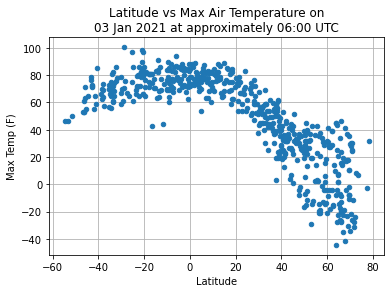

In [6]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Max Air Temperature on\n{nowString}') 
plot = weatherDataDF.plot.scatter(x = 'Latitude', y ='Max Temp (F)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
plt.savefig('outputData/1-LatitudeVsTemp.png', bbox_inches='tight')

## Latitude vs. Humidity Plot

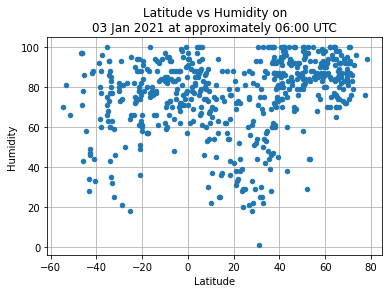

In [7]:
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Humidity on\n{nowString}') 
plot = weatherDataDF.plot.scatter(x = 'Latitude', y ='Humidity', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
plt.savefig('outputData/2-LatitudeVsHumidity.png', bbox_inches='tight')

## Latitude vs. Cloudiness Plot

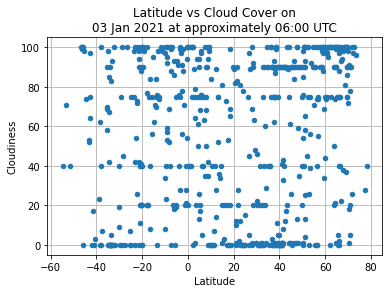

In [8]:
now = datetime.utcnow()  # These are redundant in a program, but useful in a notebook
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Cloud Cover on\n{nowString}') 
plot = weatherDataDF.plot.scatter(x = 'Latitude', y ='Cloudiness', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
plt.savefig('outputData/3-LatitudeVsCloudCover.png', bbox_inches='tight')

## Latitude vs. Wind Speed Plot

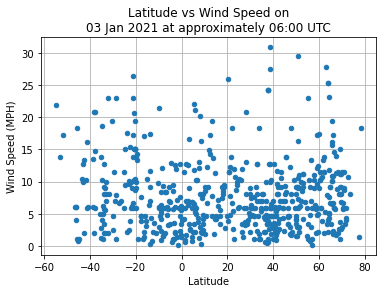

In [9]:
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Wind Speed on\n{nowString}') 
plot = weatherDataDF.plot.scatter(x = 'Latitude', y ='Wind Speed (MPH)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
plt.savefig('outputData/4-LatidudeVsWindspeed.png', bbox_inches='tight')

## Linear Regression

In [ ]:
# The linear regressions are all cut/pastes of the first plot, with changes
# to the Y axis variable and hand placed slope equations
# By defining northX and southX in the first 2 plots, I can reuse the variable 
# in subsequent graphs and minimize cut/paste errors


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7319510818249888
y = -1.31x + 89.62


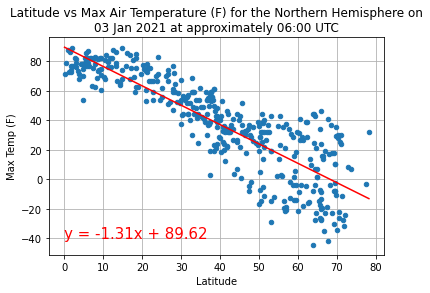

In [10]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Max Air Temperature (F) {NH}\n{nowString}') 
northDF= weatherDataDF[weatherDataDF['Latitude']>= equator]
northX = northDF['Latitude']
y_values = northDF['Max Temp (F)']
plot = northDF.plot.scatter(x = 'Latitude', y ='Max Temp (F)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(northX, y_values)
regress_values = northX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(northX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(0,-40),fontsize=15,color="red")
plt.savefig('outputData/5-NorthernLatitudeVsTempRegress.png', bbox_inches='tight')
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.2132204813190783
y = 0.35x + 81.27


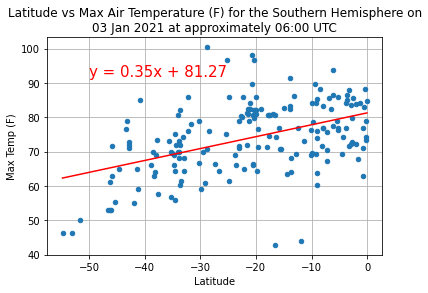

In [11]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Max Air Temperature (F) {SH}\n{nowString}') 
southDF = weatherDataDF[weatherDataDF['Latitude']< equator]
southX = southDF['Latitude']
y_values = southDF['Max Temp (F)']
plot = southDF.plot.scatter(x = 'Latitude', y ='Max Temp (F)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
# plt.grid()  <-- apparently this works without zorder nonsense
(slope, intercept, rvalue, pvalue, stderr) = linregress(southX, y_values)
regress_values = southX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(southX,regress_values,"r-", zorder =4)
plt.annotate(line_eq,(-50,92),fontsize=15,color="red")
plt.savefig('outputData/6-SouthernLatitudeVsTempRegress.png', bbox_inches='tight')
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.12540798510601917
y = 0.33x + 63.85


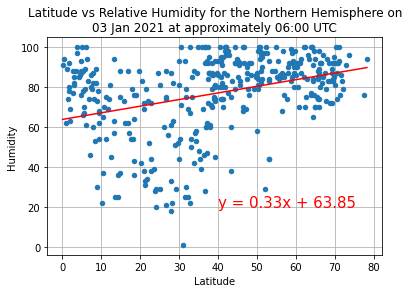

In [12]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Relative Humidity {NH}\n{nowString}') 
y_values = northDF['Humidity']
plot = northDF.plot.scatter(x = 'Latitude', y ='Humidity', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(northX, y_values)
regress_values = northX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(northX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(40,20),fontsize=15,color="red")
plt.savefig('outputData/7-NorthernLatitudeVsHumidityRegress.png', bbox_inches='tight')
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.06594452420808619
y = 0.31x + 80.69


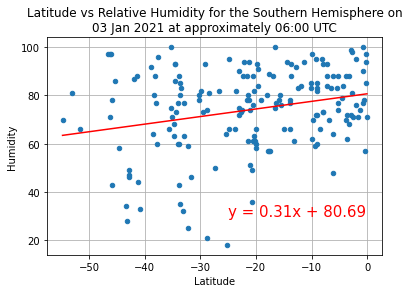

In [13]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Relative Humidity {SH}\n{nowString}') 
y_values = southDF['Humidity']
plot = southDF.plot.scatter(x = 'Latitude', y ='Humidity', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(southX, y_values)
regress_values = southX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(southX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(-25,30),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.savefig('outputData/8-SouthernLatitudeVsHumidityRegress.png', bbox_inches='tight')
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.04900643415935685
y = 0.41x + 39.44


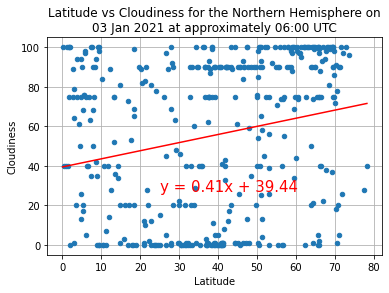

In [14]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Cloudiness {NH}\n{nowString}') 
y_values = northDF['Cloudiness']
plot = northDF.plot.scatter(x = 'Latitude', y ='Cloudiness', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(northX, y_values)
regress_values = northX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(northX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(25,27),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.savefig('outputData/9-NorthernLatitudeVsCloudinessRegress.png', bbox_inches='tight')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.04115351814066103
y = 0.55x + 66.97


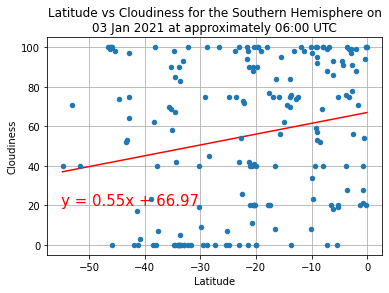

In [15]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Cloudiness {SH}\n{nowString}') 
y_values = southDF['Cloudiness']
plot = southDF.plot.scatter(x = 'Latitude', y ='Cloudiness', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(southX, y_values)
regress_values = southX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(southX,regress_values,"r-")
plt.annotate(line_eq,(-55,20),fontsize=15,color="red", zorder = 4)
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.savefig('outputData/10-SouthernLatitudeVsCloudinessRegress.png', bbox_inches='tight')
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.004737986082567345
y = 0.02x + 6.84


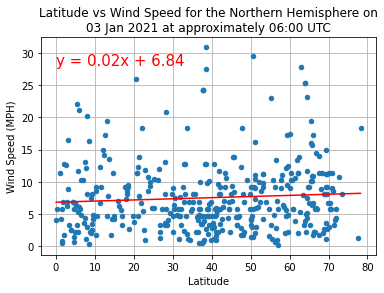

In [19]:
# It wasn't working without this import and I didn't want to rerun all 600 cities, so I re-included it 
from datetime import datetime
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Wind Speed {NH}\n{nowString}') 
y_values = northDF['Wind Speed (MPH)']
plot = northDF.plot.scatter(x = 'Latitude', y ='Wind Speed (MPH)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)

(slope, intercept, rvalue, pvalue, stderr) = linregress(northX, y_values)
regress_values = northX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(northX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(0,28),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.savefig('outputData/11-NorthernLatitudeVsWindspeedRegress.png', bbox_inches='tight')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.06100670771376541
y = -0.1x + 5.83


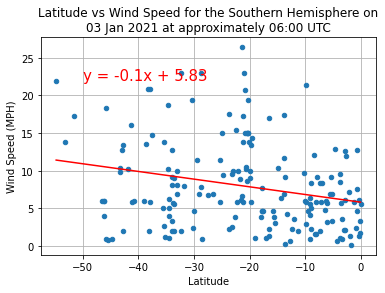

In [17]:
now = datetime.utcnow()
nowString = now.strftime("%d %b %Y at approximately %H:00 UTC")
chartTitle = (f'Latitude vs Wind Speed {SH}\n{nowString}') 
y_values = southDF['Wind Speed (MPH)']
plot = southDF.plot.scatter(x = 'Latitude', y ='Wind Speed (MPH)', title = chartTitle, zorder = 3)
plot.grid(zorder=0)
(slope, intercept, rvalue, pvalue, stderr) = linregress(southX, y_values)
regress_values = southX * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(southX,regress_values,"r-", zorder = 4)
plt.annotate(line_eq,(-50,22),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
print(line_eq)
plt.savefig('outputData/12-SouthernLatitudeVsWindspeedRegress.png', bbox_inches='tight')
plt.show()